In [1]:
from oggm import utils
import geopandas as gpd
from oggm import cfg
from oggm import tasks, utils, workflow, graphics, DEFAULT_BASE_URL, global_task
import xarray as xr
import matplotlib.pyplot as plt
from oggm.global_tasks import compile_fixed_geometry_mass_balance
import pandas as pd

from oggm.shop import gcm_climate

import numpy as np
import matplotlib.pyplot as plt

In [2]:
def get_volumes_by_scenario(glacier_name) : 
    # Initialisation du glacier_directory
    cfg.initialize(logging_level='WARNING')
    cfg.PATHS['working_dir'] = utils.gettempdir('OGGM_gcm_run', reset=True)
    rgi_ids = [glacier_name]
    gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=5, prepro_base_url=DEFAULT_BASE_URL)

    # Download and process GCM data from ISIMIP3b (bias-corrected CMIP6)
    # C'est déjà calculé sur leurs serveurs (ils ont 3 scénarios SSP de pêts) donc on les télécharge
    member = 'mri-esm2-0_r1i1p1f1' 

    for ssp in ['ssp126', 'ssp370','ssp585']:
        # bias correct them
        workflow.execute_entity_task(gcm_climate.process_monthly_isimip_data, gdirs, 
                                    ssp = ssp,
                                    # gcm member -> you can choose another one
                                    member=member,
                                    # recognize the climate file for later
                                    output_filesuffix=f'_ISIMIP3b_{member}_{ssp}'
                                    );

    # Si on veut des infos sur le climat: 
    #print(gdirs[0].get_climate_info())

    # On lance les calculs de projection dans le futur pour chacun des 3 scénarios SSP
    for ssp in ['ssp126', 'ssp370', 'ssp585']:
        rid = f'_ISIMIP3b_{member}_{ssp}'
        workflow.execute_entity_task(tasks.run_from_climate_data, gdirs,
                                    climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                    climate_input_filesuffix=rid,  # use the chosen scenario
                                    init_model_filesuffix='_spinup_historical',  # this is important! Start from 2020 glacier
                                    output_filesuffix=rid,  # recognize the run for later
                                    );
    
    # On récupère les données de volume pour chaque scénario
    # On plot les volumes pour chaque scénario
    color_dict={'ssp126':'blue', 'ssp370':'orange', 'ssp585':'red'}
    scenarios = []
    for ssp in ['ssp126','ssp370', 'ssp585']:
        rid = f'_ISIMIP3b_{member}_{ssp}'
        # Compile the output into one file
        ds = utils.compile_run_output(gdirs, input_filesuffix=rid)
        scenarios.append(ds)
        print(ds)
        # Plot it
        ds.isel(rgi_id=0).volume.plot(label=ssp, c=color_dict[ssp]);
    plt.legend();
    return scenarios

2024-05-06 16:22:07: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-05-06 16:22:07: oggm.cfg: Multiprocessing switched OFF according to the parameter file.


2024-05-06 16:22:07: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-05-06 16:22:08: oggm.workflow: init_glacier_directories from prepro level 5 on 1 glaciers.
2024-05-06 16:22:08: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-05-06 16:22:10: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-05-06 16:22:12: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-05-06 16:22:13: oggm.workflow: Execute entity tasks [process_monthly_isimip_data] on 1 glaciers
2024-05-06 16:22:15: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-05-06 16:22:15: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-05-06 16:22:15: oggm.workflow: Execute entity tasks [run_from_climate_data] on 1 glaciers
2024-05-06 16:22:16: oggm.utils: Applying global task compile_run_output on 1 glaciers
2024-05-06 16:22:16: oggm.utils: Applying compile_run_

<xarray.Dataset>
Dimensions:         (time: 82, rgi_id: 1)
Coordinates:
  * time            (time) float64 2.02e+03 2.021e+03 ... 2.1e+03 2.101e+03
  * rgi_id          (rgi_id) <U14 'RGI60-11.03643'
    hydro_year      (time) int64 2020 2021 2022 2023 ... 2098 2099 2100 2101
    hydro_month     (time) int64 4 4 4 4 4 4 4 4 4 4 4 ... 4 4 4 4 4 4 4 4 4 4 4
    calendar_year   (time) int64 2020 2021 2022 2023 ... 2098 2099 2100 2101
    calendar_month  (time) int64 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1
Data variables:
    volume          (time, rgi_id) float64 1.723e+09 1.71e+09 ... 8.762e+08
    volume_bsl      (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    volume_bwl      (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    area            (time, rgi_id) float64 2.287e+07 2.282e+07 ... 1.471e+07
    length          (time, rgi_id) float64 9.322e+03 9.322e+03 ... 2.844e+03
    calving         (time, rgi_id) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
  

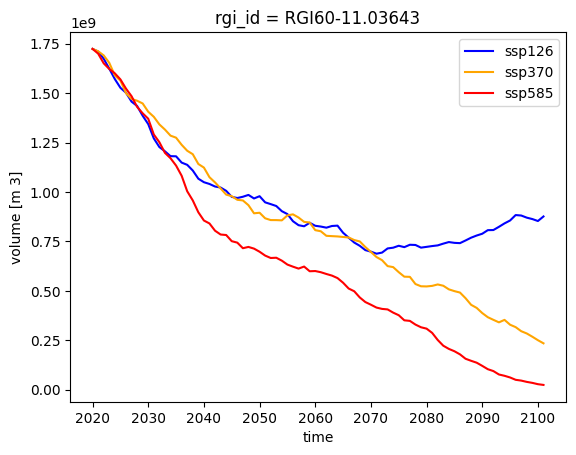

In [3]:
glacier = 'RGI60-11.03643'

volumes_futurs = get_volumes_by_scenario(glacier)
years_proj = volumes_futurs[0].time.values

# Prédictions par scénarios

In [4]:
volumes_s1 = volumes_futurs[0].volume.values
volumes_s2 = volumes_futurs[1].volume.values
volumes_s3 = volumes_futurs[2].volume.values

In [5]:
volumes_s1_values = np.squeeze(volumes_s1)
volumes_s2_values = np.squeeze(volumes_s2)
volumes_s3_values = np.squeeze(volumes_s3)

In [6]:
print(volumes_s1.shape)
print(volumes_s1_values.shape)

(82, 1)
(82,)


In [7]:
volumes_s1

array([[1.72348474e+09],
       [1.71031622e+09],
       [1.67380680e+09],
       [1.62364860e+09],
       [1.57098505e+09],
       [1.52703253e+09],
       [1.50206323e+09],
       [1.45698308e+09],
       [1.43492410e+09],
       [1.38546518e+09],
       [1.34317134e+09],
       [1.27109259e+09],
       [1.22720223e+09],
       [1.20555915e+09],
       [1.18118926e+09],
       [1.18039049e+09],
       [1.14859624e+09],
       [1.13727336e+09],
       [1.10855961e+09],
       [1.06712744e+09],
       [1.04944243e+09],
       [1.04051809e+09],
       [1.02761177e+09],
       [1.02238033e+09],
       [1.00569213e+09],
       [9.75258102e+08],
       [9.69490084e+08],
       [9.75812765e+08],
       [9.85130217e+08],
       [9.67207438e+08],
       [9.78689867e+08],
       [9.47588641e+08],
       [9.38584132e+08],
       [9.29035818e+08],
       [9.02845400e+08],
       [8.88182689e+08],
       [8.52047126e+08],
       [8.32017835e+08],
       [8.26539559e+08],
       [8.44195346e+08],


# Dérivée
Pour calculer le flux d'eau généré par la fonte du glacier.

La dérivée c'est le flux perdu = négatif. -dérivée c'est le flux d'eau généré par le glacier (gagné par les cours d'eau) = positif

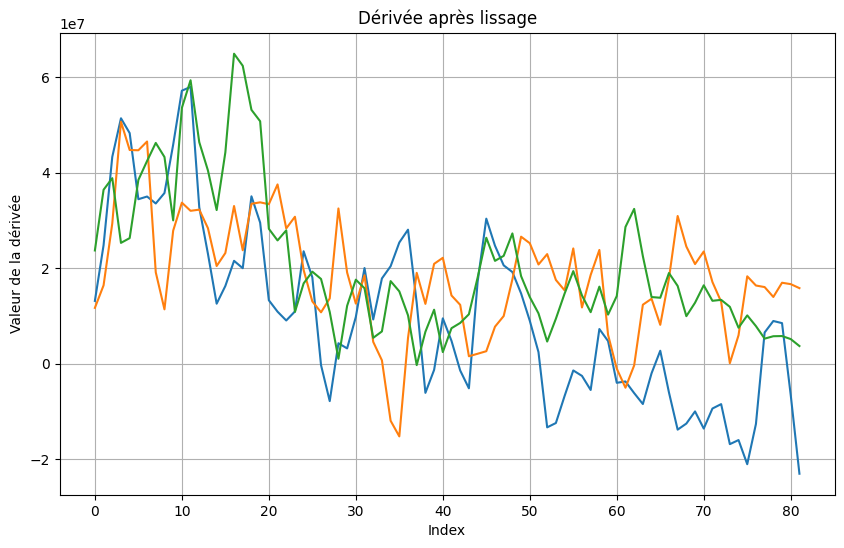

In [8]:
# Calcul de la dérivée sur les données lissées
gradient_array_S1 = -np.gradient(volumes_s1_values, edge_order=1)
gradient_array_S2 = -np.gradient(volumes_s2_values, edge_order=1)
gradient_array_S3 = -np.gradient(volumes_s3_values, edge_order=1)

# Tracez le résultat
plt.figure(figsize=(10, 6))
plt.plot(gradient_array_S1, label="S1 Dérivée après lissage")
plt.plot(gradient_array_S2, label="S2 Dérivée après lissage")
plt.plot(gradient_array_S3, label="S3 Dérivée après lissage")
plt.title("Dérivée après lissage")
plt.xlabel("Index")
plt.ylabel("Valeur de la dérivée")
plt.grid(True)
plt.show()


# Concaténation données réelles

In [9]:
def initializa_gdir(glacier_name = 'RGI60-15.03473') :
    # Initialize OGGM and set up the default run parameters
    cfg.initialize(logging_level='WARNING')

    # Local working directory (where OGGM will write its output)
    # WORKING_DIR = utils.gettempdir('OGGM_distr4')
    cfg.PATHS['working_dir'] = utils.get_temp_dir('OGGM_distributed', reset=True)

    rgi_ids = [glacier_name]  # This is Aletsch
    gdir = workflow.init_glacier_directories(rgi_ids, prepro_base_url=DEFAULT_BASE_URL, from_prepro_level=4, prepro_border=80)[0]
    return gdir

In [10]:
gdir = initializa_gdir(glacier)
ds = utils.compile_run_output(gdir, input_filesuffix='_spinup_historical') # sert à récupérer les données de volume

2024-05-06 16:22:17: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2024-05-06 16:22:17: oggm.cfg: Multiprocessing switched OFF according to the parameter file.
2024-05-06 16:22:17: oggm.cfg: Multiprocessing: using all available processors (N=8)
2024-05-06 16:22:17: oggm.workflow: init_glacier_directories from prepro level 4 on 1 glaciers.
2024-05-06 16:22:17: oggm.workflow: Execute entity tasks [gdir_from_prepro] on 1 glaciers
2024-05-06 16:22:19: oggm.utils: Applying global task compile_run_output on 1 glaciers
2024-05-06 16:22:19: oggm.utils: Applying compile_run_output on 1 gdirs.


In [11]:
volume_reel = ds.volume.values
years_reel = ds.time.values

volume_reel = np.squeeze(volume_reel)

# Derivative real values

In [12]:
gradient_real_values = -np.gradient(-np.gradient(volume_reel[:-1]), edge_order=1)

# Concaténation

In [13]:
scenario_1_ssp126 = np.concatenate((gradient_real_values, gradient_array_S1))
scenario_2_ssp370 = np.concatenate((gradient_real_values, gradient_array_S2))
scenario_3_ssp585 = np.concatenate((gradient_real_values, gradient_array_S3))
years_total = np.concatenate((years_reel[:-1], years_proj))

index_2020 = np.where(years_total == 2020)[0][0]

In [14]:
# volumes_s1_transposed = np.transpose(gradient_scenario_1_ssp126)
# volumes_s2_transposed = np.transpose(gradient_scenario_2_ssp370)
# volumes_s3_transposed = np.transpose(gradient_scenario_3_ssp585)

# volumes_s1_values = np.squeeze(volumes_s1_transposed)
# volumes_s2_values = np.squeeze(volumes_s2_transposed)
# volumes_s3_values = np.squeeze(volumes_s3_transposed)

# Fitter la courbe

In [15]:
degree = 10  # Degré du polynôme d'ajustement

x_S1 = np.arange(len(scenario_1_ssp126))
x_S2 = np.arange(len(scenario_2_ssp370))
x_S3 = np.arange(len(scenario_3_ssp585))


# Effectuez une régression polynomiale
coefficients_S1 = np.polyfit(x_S1, scenario_1_ssp126, degree)
coefficients_S2 = np.polyfit(x_S2, scenario_2_ssp370, degree)
coefficients_S3 = np.polyfit(x_S3, scenario_3_ssp585, degree)

polynomial_S1 = np.poly1d(coefficients_S1)
polynomial_S2 = np.poly1d(coefficients_S2)
polynomial_S3 = np.poly1d(coefficients_S3)

fitted_curve_S1 = polynomial_S1(x_S1)
fitted_curve_S2 = polynomial_S2(x_S2)
fitted_curve_S3 = polynomial_S3(x_S3)

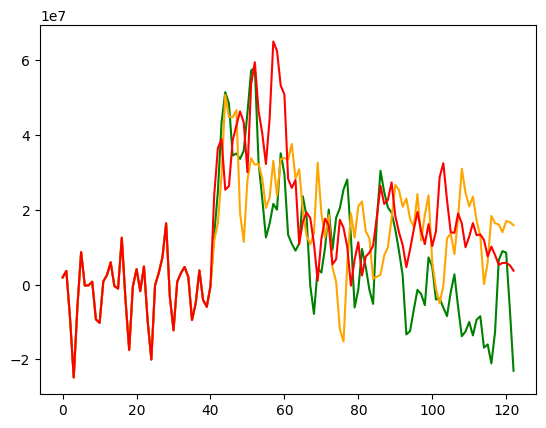

In [16]:
plt.plot(scenario_1_ssp126, color='green')
plt.plot(scenario_2_ssp370, color='orange')
plt.plot(scenario_3_ssp585, color='red')

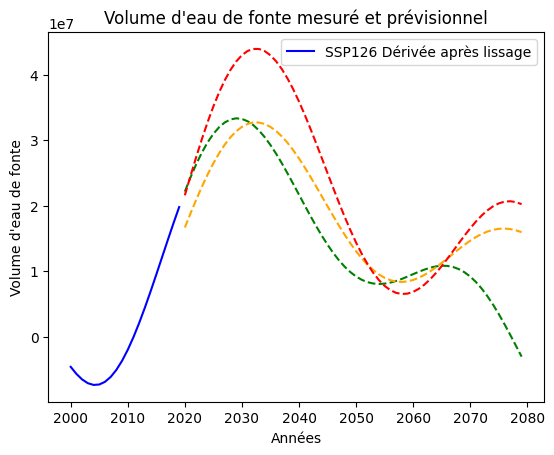

In [17]:
# Diviser les données en deux ensembles : avant 2020 et après 2020
annee_min = 2000
annee_max = 2080

index_min = np.where(years_total == annee_min)[0][0]
index_max = np.where(years_total == annee_max)[0][0]


years_before_2020 = years_total[index_min:index_2020]
years_after_2020 = years_total[index_2020:index_max]

# Valuers avant 2020
fitted_curve_S1_before_2020 = fitted_curve_S1[index_min:index_2020]
fitted_curve_S2_before_2020 = fitted_curve_S2[index_min:index_2020]
fitted_curve_S3_before_2020 = fitted_curve_S3[index_min:index_2020]

# Valeurs après 2020
fitted_curve_S1_after_2020 = fitted_curve_S1[index_2020:index_max]
fitted_curve_S2_after_2020 = fitted_curve_S2[index_2020:index_max]
fitted_curve_S3_after_2020 = fitted_curve_S3[index_2020:index_max]


# Tracer les courbes avant 2020
plt.plot(years_before_2020, fitted_curve_S1_before_2020, label="SSP126 Dérivée après lissage",  color='blue')
# plt.plot(years_before_2020, fitted_curve_S2_before_2020, label="SSP370 Dérivée après lissage",  color='orange')
# plt.plot(years_before_2020, fitted_curve_S3_before_2020, label="S3585 Dérivée après lissage",  color='red')

# Tracer les courbes après 2020 en pointillés
plt.plot(years_after_2020, fitted_curve_S1_after_2020, linestyle='--', color='green')
plt.plot(years_after_2020, fitted_curve_S2_after_2020, linestyle='--', color='orange')
plt.plot(years_after_2020, fitted_curve_S3_after_2020, linestyle='--', color='red')

plt.title("Volume d'eau de fonte mesuré et prévisionnel")
plt.xlabel("Années")
plt.ylabel("Volume d'eau de fonte")
plt.legend()
plt.show()


In [19]:
fitted_curve_S1[:10]

array([ 6232741.0139753 , -2863560.54934068, -7830211.77305864,
       -9824398.36493242, -9780118.23574277, -8439099.06917377,
       -6378588.29078931, -4036244.07234228, -1732344.45104461,
         310479.5492079 ])

/tmp/ipykernel_3333/3895362936.py:21: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(years_total_c[0], fitted_curve_S1[0])
/tmp/ipykernel_3333/3895362936.py:21: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(years_total_c[0], fitted_curve_S1[0])


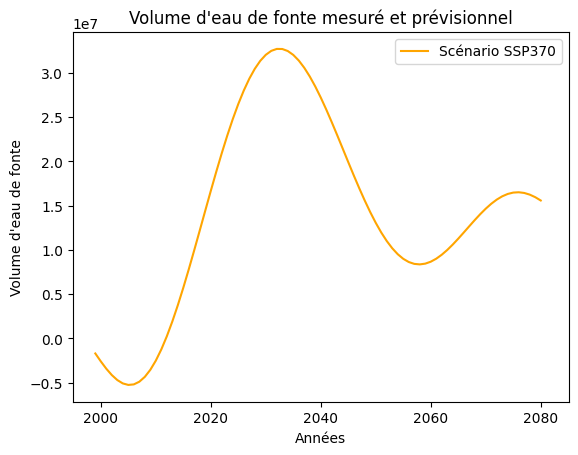

In [59]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

crop = 20

years_total_c = years_total[crop:-crop]
fitted_curve_S2_c = fitted_curve_S2[crop:-crop]

# Initialisation de la figure et du tracé
fig, ax = plt.subplots()
line, = ax.plot(years_total_c, fitted_curve_S2_c, label="Scénario SSP370", color='orange')
ax.set_title("Volume d'eau de fonte mesuré et prévisionnel")
ax.set_xlabel("Années")
ax.set_ylabel("Volume d'eau de fonte")
ax.legend()


# Fonction d'initialisation de l'animation
def init():
    line.set_data(years_total_c[0], fitted_curve_S1[0])
    return line,

# Fonction de mise à jour de l'animation
def update(frame):
    x_data = years_total_c[:frame]
    y_data = fitted_curve_S2_c[:frame]
    line.set_data(x_data, y_data)
    return line,

# Création de l'animation
ani = FuncAnimation(fig, update, frames=len(years_total_c), init_func=init, blit=True)

HTML(ani.to_jshtml())


# ANIMATION Scenario 1

/tmp/ipykernel_3333/3918205447.py:31: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(years_total_c[0], fitted_curve_S1[0])
/tmp/ipykernel_3333/3918205447.py:31: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  line.set_data(years_total_c[0], fitted_curve_S1[0])


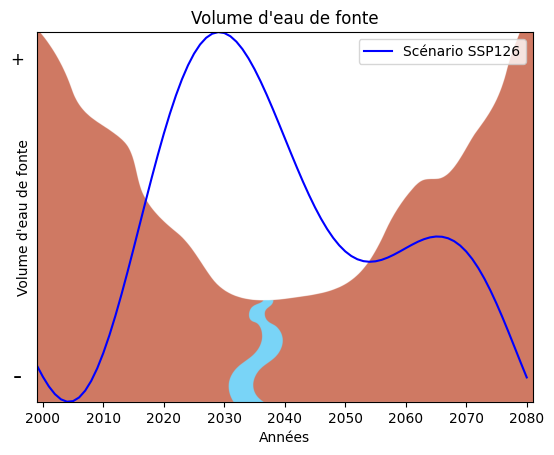

In [84]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

crop = 20

years_total_c = years_total[crop:-crop]
fitted_curve_S3_c = fitted_curve_S1[crop:-crop]

# Initialisation de la figure et du tracé
fig, ax = plt.subplots()
line, = ax.plot(years_total_c, fitted_curve_S3_c, label="Scénario SSP126", color='blue')
ax.set_title("Volume d'eau de fonte")
ax.set_xlabel("Années")
ax.set_ylabel("Volume d'eau de fonte")
ax.set_yticks([])
ax.set_yticklabels([])

# Ajouter les marqueurs "+" et "-"
ax.text(-0.04, 0.9, '+', ha='center', va='bottom', fontsize=12, transform=ax.transAxes)
ax.text(-0.04, 0.1, '-', ha='center', va='top', fontsize=18, transform=ax.transAxes)
ax.legend()

image1 = plt.imread('riviere_1.png')
image2 = plt.imread('riviere_2.png')
image3 = plt.imread('riviere_3.png')
background = ax.imshow(image3, aspect='auto', extent=[years_total_c[0], years_total_c[-1], min(fitted_curve_S3_c), max(fitted_curve_S3_c)], zorder=-1)

# Fonction d'initialisation de l'animation
def init():
    line.set_data(years_total_c[0], fitted_curve_S1[0])
    background.set_data(image3)
    return line,

# Fonction de mise à jour de l'animation
def update(frame):
    if fitted_curve_S3_c[frame-1] < 1.5 * 1e7:
        background.set_data(image1)
    elif fitted_curve_S3_c[frame-1] < 2.5 * 1e7:
        background.set_data(image2)
    else:
        background.set_data(image3)

    x_data = years_total_c[:frame]
    y_data = fitted_curve_S3_c[:frame]
    line.set_data(x_data, y_data)

    return line,

# Création de l'animation
ani = FuncAnimation(fig, update, frames=len(years_total_c), init_func=init, blit=True)

animation_html = ani.to_jshtml()

with open("flux_rivieres_SSP126.html", "w") as html_file:
    html_file.write(animation_html);